The Basic data loading and the reduce memory function were taken from these 2 great kernel

https://www.kaggle.com/kyakovlev/m5-simple-fe


https://www.kaggle.com/gopidurgaprasad/m5-forecasting-eda-lstm-pytorch-modeling/notebook?scriptVersionId=31373530

# Table Of Contents

* [<font size=4>Load Data</font>](#2)
* [<font size=4>One Time Series</font>](#3)
* [<font size=4>Normlize Data</font>](#4)
* [<font size=4>Create Sequances</font>](#5)
* [<font size=4>Simple LSTM model</font>](#6)
* [<font size=4>Multiple LSTM layers</font>](#7)
* [<font size=4>Add Features </font>](#8)







### Load Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

#pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv('/content/drive/MyDrive/M5/sell_prices.csv')
    #sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv( '/content/drive/MyDrive/M5/calendar.csv')
    #calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv( '/content/drive/MyDrive/M5/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv('/content/drive/MyDrive/M5/sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df


# Load Data <a id="2"></a>

In [7]:
_,  calendar_df, sales_train_validation_df, _ = read_data()

Sell prices has 6841121 rows and 4 columns
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


In [8]:
calendar_df.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [9]:
sales_train_validation_df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

## Date List
Here we create dates list, that will help later on to display the Time Series, with the right dates

In [10]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

### Some Simple EDA

In [11]:
sales_train_validation_df.loc[sales_train_validation_df['store_id'] == 'CA_1']

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

there are a total of 3049 items for sale on CA_1, 3 categories and 7 departments in total.

In [12]:
# detailed products distribution in CA_1
ca_1_sales = sales_train_validation_df.loc[sales_train_validation_df['store_id'] == 'CA_1']
pd.crosstab(ca_1_sales['cat_id'], ca_1_sales['dept_id'])

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
cat_id,,,,,,,
FOODS,216,398,823,0,0,0,0
HOBBIES,0,0,0,416,149,0,0
HOUSEHOLD,0,0,0,0,0,532,515


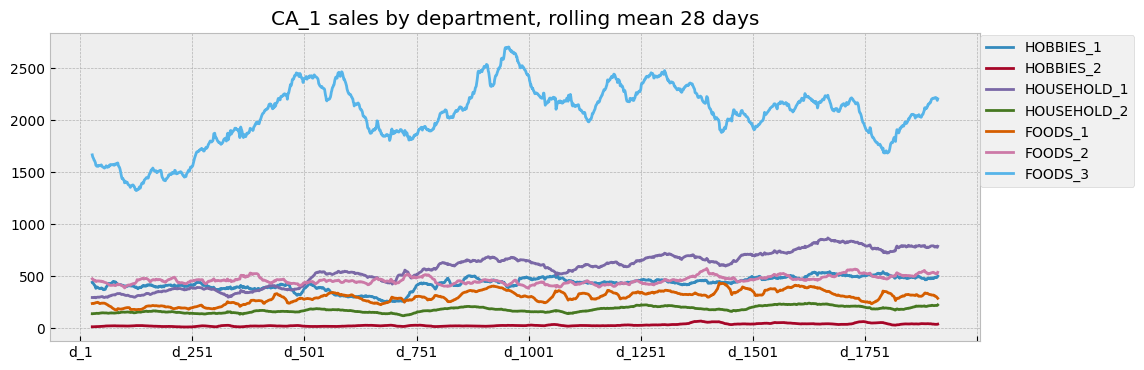

In [13]:
plt.figure(figsize=(12, 4))
for d in ca_1_sales['dept_id'].unique():
    store_sales = ca_1_sales.loc[ca_1_sales['dept_id'] == d]
    store_sales.iloc[:, 6:].sum().rolling(28).mean().plot(label=d)
plt.title('CA_1 sales by department, rolling mean 28 days')
plt.legend(loc=(1.0, 0.5));

Products sales in different departments have distinct performances. We'll take that into consideration when we analyze the TS.

# Select One Time Series to predict <a id="3"></a>
Selecting one Time Series(one department in CA_1) here.

In [14]:
#DF_Sales=sales_train_validation_df.groupby('store_id').mean().T
DF_Sales=sales_train_validation_df[sales_train_validation_df['store_id'] == 'CA_1'].groupby('dept_id').mean().T
#DF_Sales=sales_train_validation_df.groupby('cat_id').mean().T

In [15]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index
#sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
#DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913']
#DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index
DF_Sales = DF_Sales.set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

dept_id,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2
2011-01-29,1.375000,1.693467,2.755772,1.269231,0.187919,0.678571,0.351456
2011-01-30,1.314815,1.645729,2.670717,1.175481,0.060403,0.657895,0.330097
2011-01-31,0.990741,0.994975,1.698663,0.983173,0.040268,0.524436,0.221359
2011-02-01,0.810185,1.195980,1.952612,0.920673,0.060403,0.522556,0.238835
2011-02-02,0.842593,0.889447,1.817740,0.632212,0.033557,0.366541,0.262136


## Plot The TS

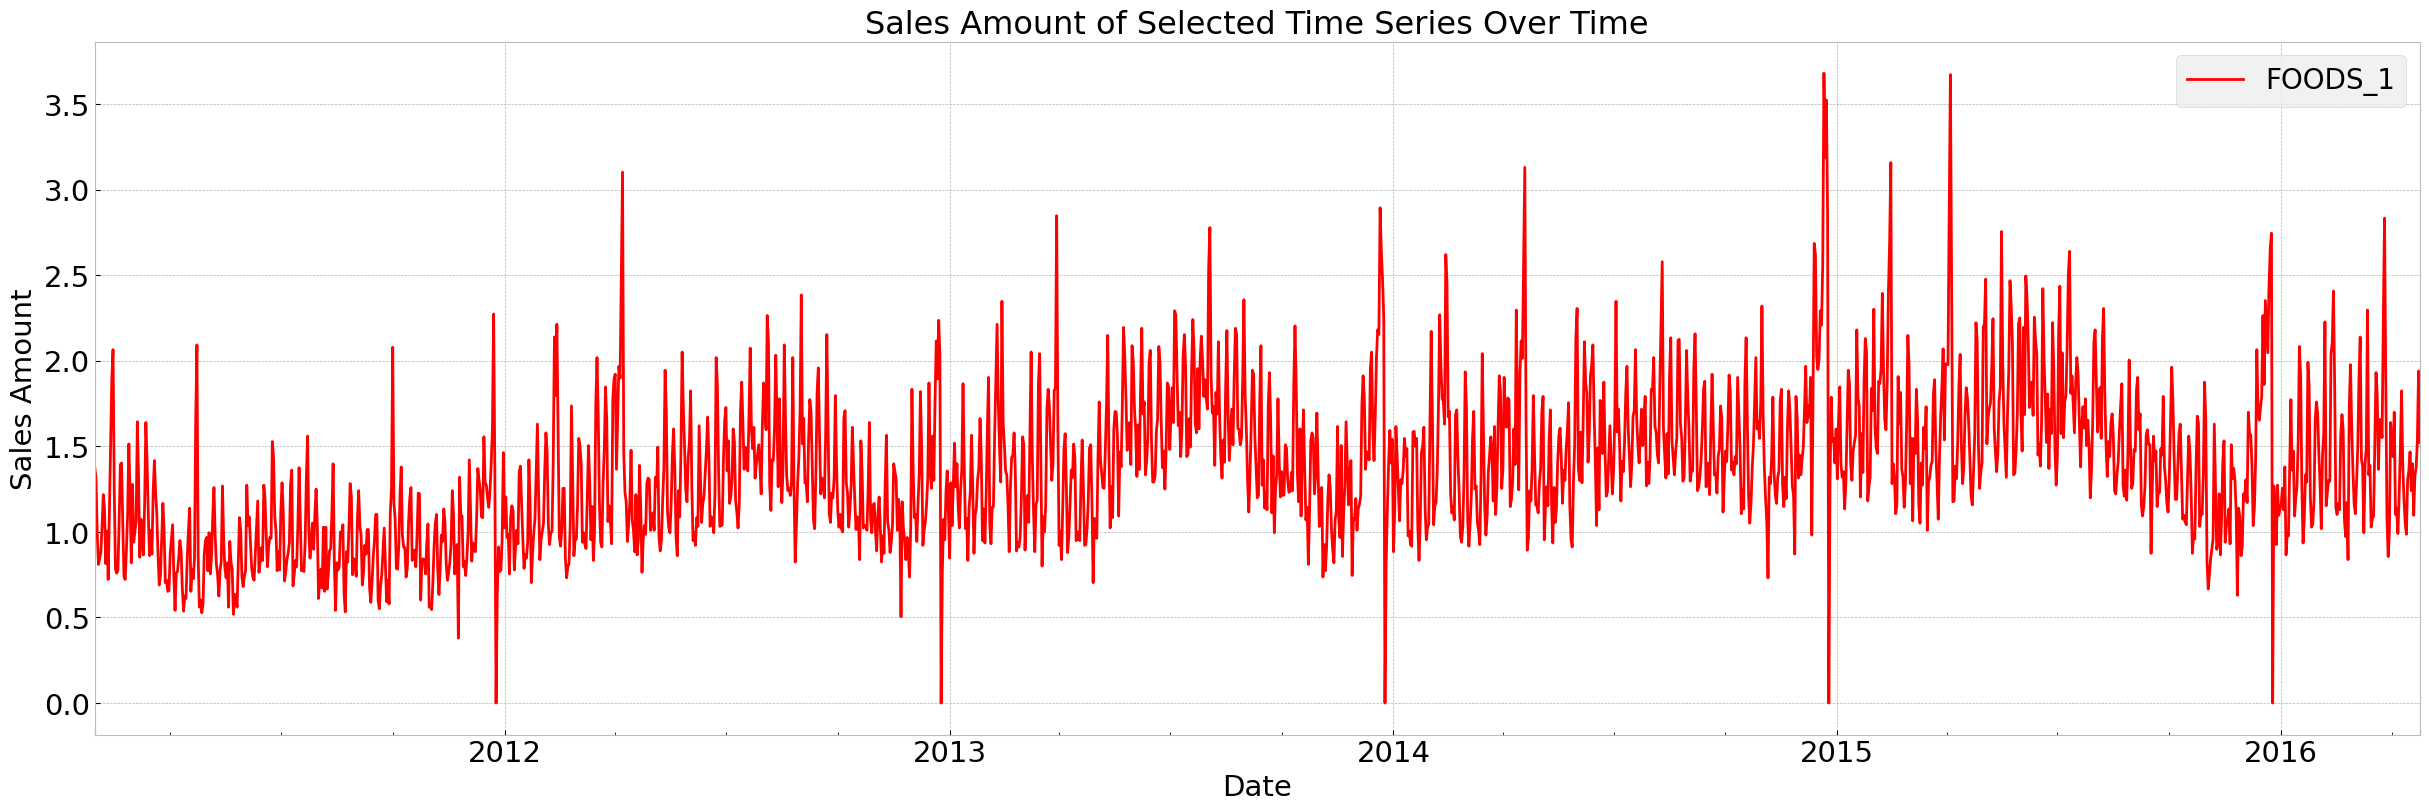

In [16]:
#Select arbitrary index and plot the time series
index = 0
y = pd.DataFrame(DF_Sales.iloc[:,index])
#y = y.set_index([dates_list])
TS_selected = y
#y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('white')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Amount of Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Amount',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


In [17]:
#del calendar_df, sales_train_validation_df,DF_Sales
#gc.collect()

## SEED all

In [18]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

## Normlize Data <a id="4"></a>

Normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively

In [19]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data)

In [20]:
train_data_normalized

array([[-0.25283019],
       [-0.28553459],
       [-0.46163522],
       ...,
       [-0.1672956 ],
       [ 0.05408805],
       [-0.17232704]])

# Create Sliding Window <a id="5"></a>

In [21]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

Lets see the shape of our data

In [22]:
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


## Split Data <a id="6"></a>


In [23]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [24]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


# Simple LSTM model <a id="6"></a>
In this section, we create the Pytorch LSTM model.
The Model has one LST layer and one dense input layer.

In [25]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=0.2)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        out = self.dropout(out)

        return out

In [85]:
#####  Parameters  ######################
num_epochs = 50
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)):
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))

    loss.backward()


    optimizer.step()

    #Evaluate on test
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)

    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))


Epoch: 0, loss: 0.12538 valid loss:  0.05819 


## Predict on Entire Data Set

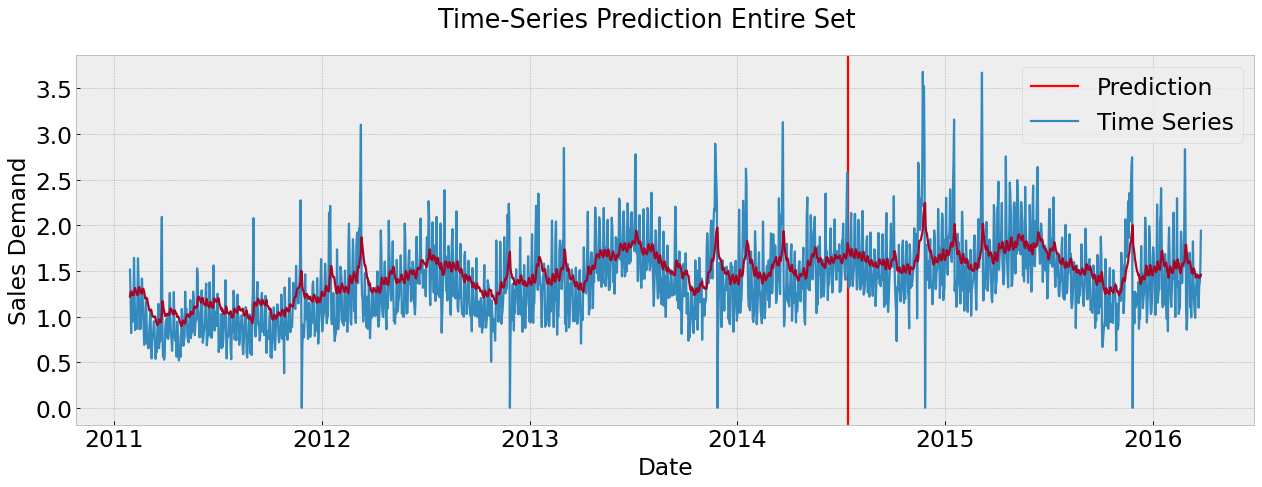

In [86]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


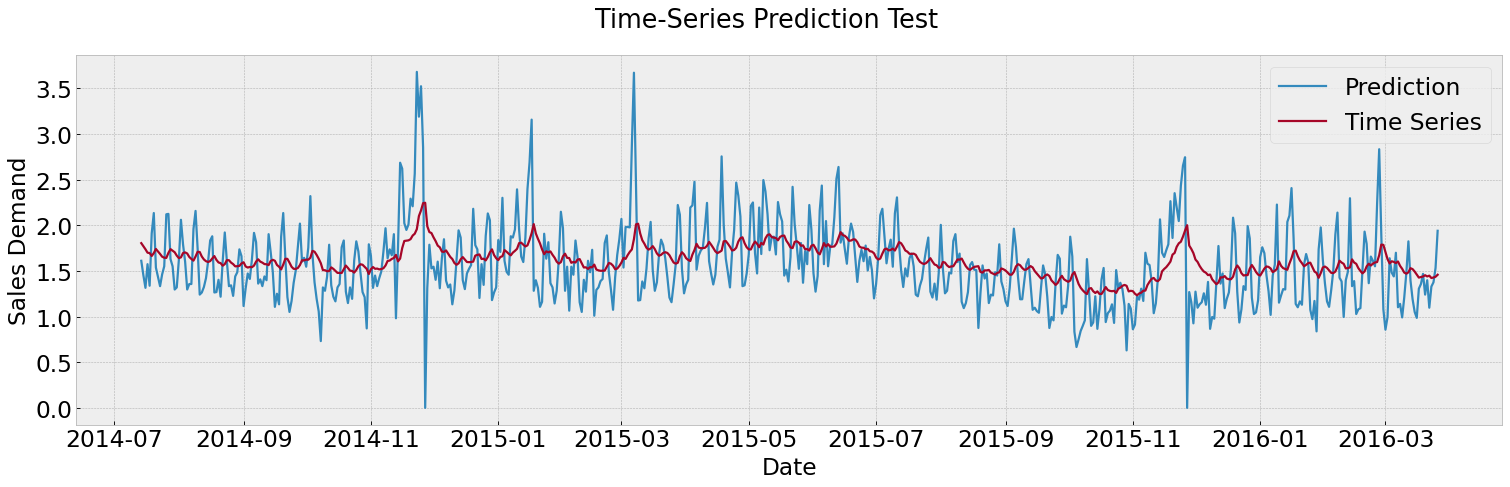

In [87]:

#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

### Train & Test RMSE

In [88]:
np.sqrt(((dataY_plot[-trainX.size()[0]:] - data_predict[-trainX.size()[0]:] ) ** 2).mean())

0.3799694

In [89]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

0.39649177

# Multiple LSTM layers <a id="7"></a>
We can Enhance the net by using multiple LSTM layers.

In [78]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers,dropout_prob=0.5):
        super(LSTM2, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.batch_size = 1
        #self.seq_length = seq_length

        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.5)

        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))


        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))


        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))

        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)

        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out


In [79]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [92]:
num_epochs = 400
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 5

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in progress_bar(range(num_epochs)):
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))

    loss.backward()

    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)

    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.19177 valid loss:  0.95656 
Epoch: 50, loss: 0.03576 valid loss:  0.05364 
Epoch: 100, loss: 0.03383 valid loss:  0.04815 
Epoch: 150, loss: 0.02472 valid loss:  0.03887 
Epoch: 200, loss: 0.02279 valid loss:  0.03587 
Epoch: 250, loss: 0.02044 valid loss:  0.03480 
Epoch: 300, loss: 0.01799 valid loss:  0.03107 
Epoch: 350, loss: 0.01567 valid loss:  0.03196 


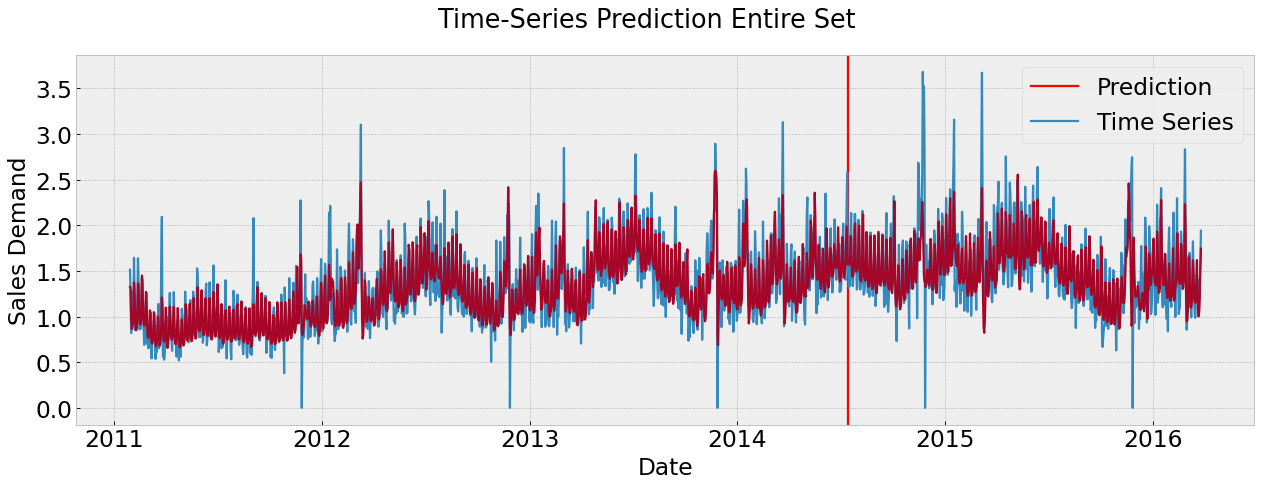

In [93]:
######Prediction###############
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()


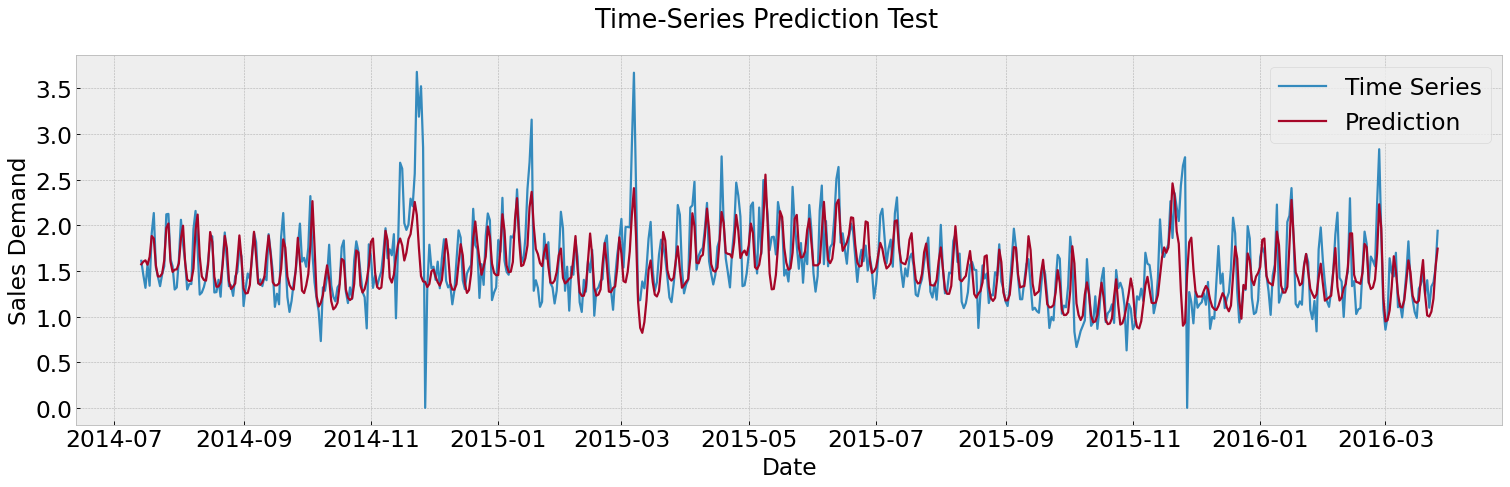

In [94]:

#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Time Series','Prediction'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

### Train & Test RMSE

In [95]:
np.sqrt(((dataY_plot[-trainX.size()[0]:] - data_predict[-trainX.size()[0]:] ) ** 2).mean())

0.27903187

In [96]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

0.32560053

### Some further explorations and error analysis on prediction

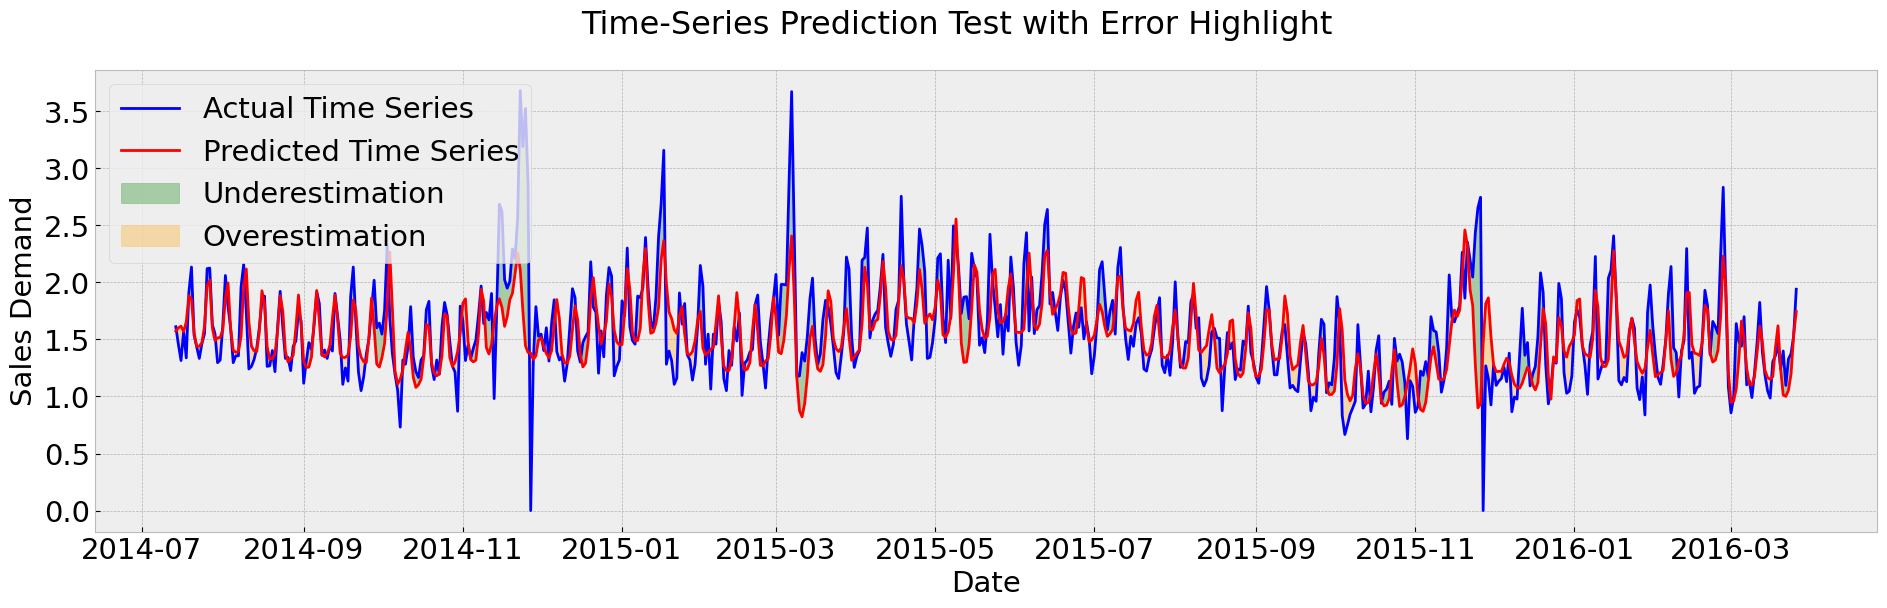

In [97]:
plt.figure(figsize=(23, 6))
plt.plot(df_labels.iloc[-testX.size()[0]:][0], label='Actual Time Series', color='blue')
plt.plot(df_predict.iloc[-testX.size()[0]:][0], label='Predicted Time Series', color='red')

# Highlighting areas of deviation
deviation = df_labels.iloc[-testX.size()[0]:][0] - df_predict.iloc[-testX.size()[0]:][0]
plt.fill_between(df_labels.iloc[-testX.size()[0]:].index,
                 df_labels.iloc[-testX.size()[0]:][0],
                 df_predict.iloc[-testX.size()[0]:][0],
                 where=deviation>0, color='green', alpha=0.3, label='Underestimation')
plt.fill_between(df_labels.iloc[-testX.size()[0]:].index,
                 df_labels.iloc[-testX.size()[0]:][0],
                 df_predict.iloc[-testX.size()[0]:][0],
                 where=deviation<0, color='orange', alpha=0.3, label='Overestimation')

plt.legend(fontsize=21)
plt.suptitle('Time-Series Prediction Test with Error Highlight', fontsize=23)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.ylabel('Sales Demand', fontsize=21)
plt.xlabel('Date', fontsize=21)
plt.show()

In this plot, presented a comparison of  LSTM model's predictions against the actual sales demand data. The blue line represents the true sales data, while the red line illustrates the predictions made by the model. Areas where the model's predictions fall short of the actual values are shaded in green, indicating underestimations. Conversely, areas where predictions surpass the actual sales are shaded in orange, signifying overestimations. The plot demonstrates my model's ability to closely mirror the sales demand patterns, although, like any forecast, it's not without occasional deviations from the actual figures. This visual insight into the model's performance is crucial for understanding and improving its predictive capabilities.

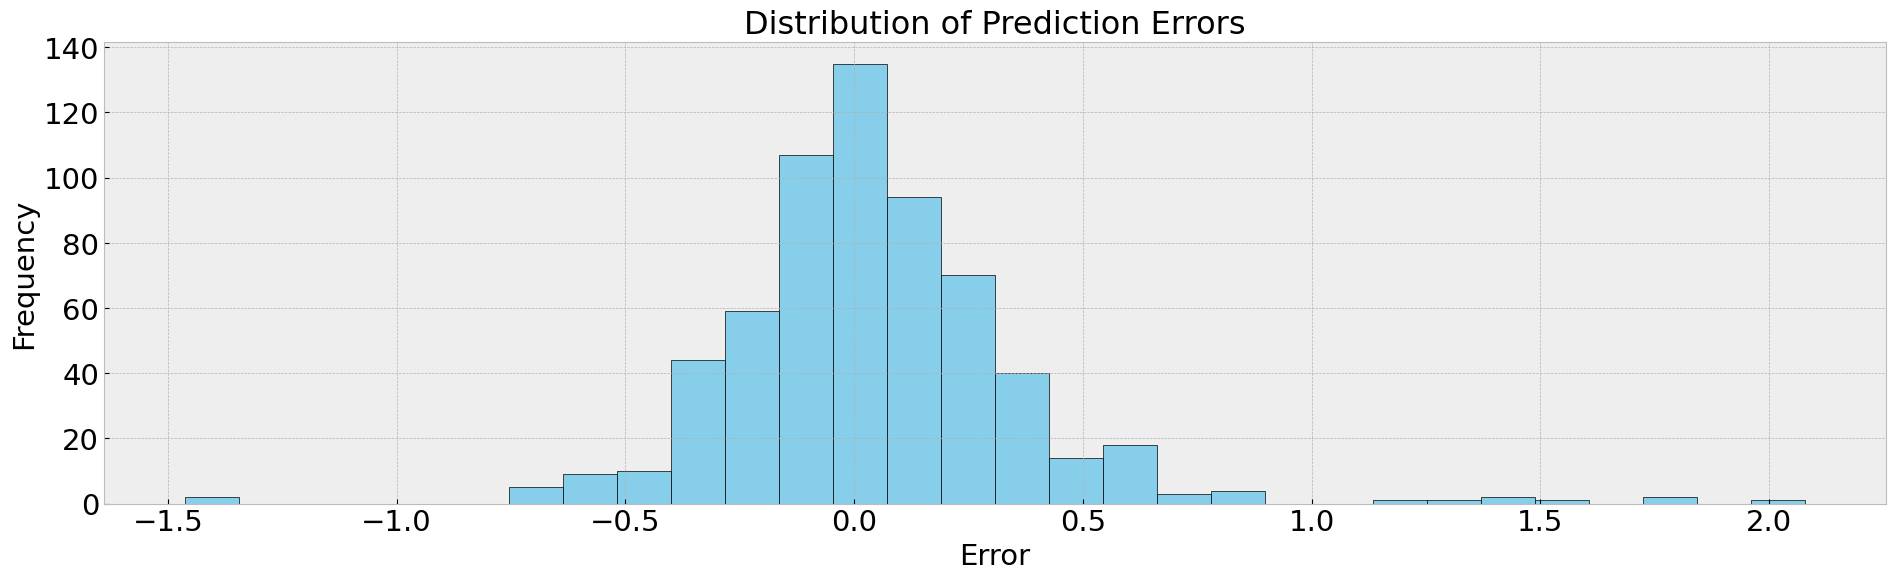

In [98]:
errors = df_labels.iloc[-testX.size()[0]:][0] - df_predict.iloc[-testX.size()[0]:][0]
plt.figure(figsize=(23, 6))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Errors', fontsize=23)
plt.xlabel('Error', fontsize=21)
plt.ylabel('Frequency', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.show()

In this histogram, we can observe the distribution of prediction errors for the LSTM model's forecasts. The x-axis denotes the error magnitude, with negative values indicating underestimations and positive values representing overestimations of sales demand. The y-axis shows the frequency of these errors. The bulk of the errors cluster around zero, suggesting that most predictions are quite close to the actual values, which is indicative of a well-performing model. There are a few instances of larger errors, but these are less frequent. This distribution provides a clear visual indication that my model is accurate with a tendency for slight overestimation as seen by the skew towards the positive side.

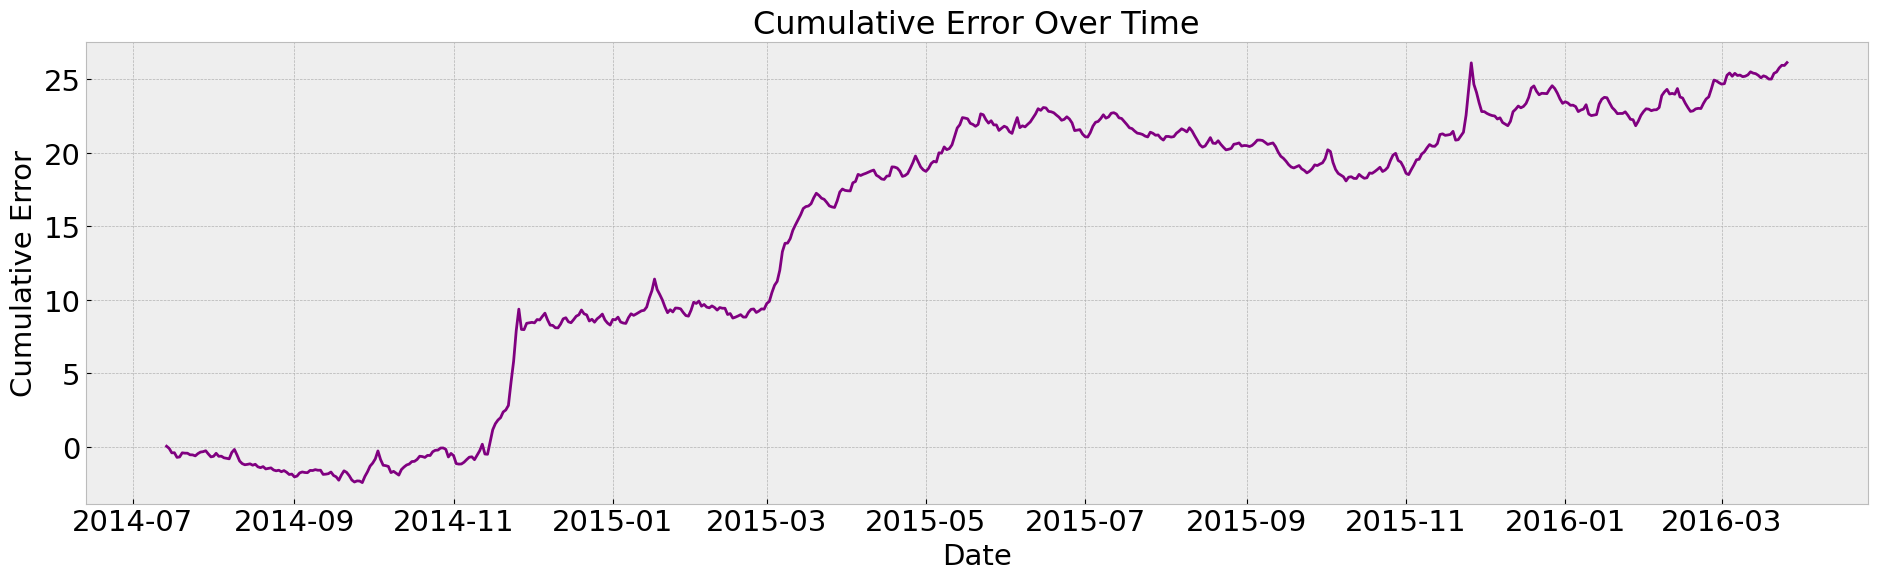

In [99]:
cumulative_error = errors.cumsum()
plt.figure(figsize=(23, 6))
cumulative_error.plot(color='purple')
plt.title('Cumulative Error Over Time', fontsize=23)
plt.xlabel('Date', fontsize=21)
plt.ylabel('Cumulative Error', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.show()

From the plot, we can observe that the cumulative error starts relatively flat, indicating that the model's predictions are fairly accurate at the beginning of the forecast horizon. As time progresses, we see some increases in the cumulative error, reflecting periods where the prediction errors are higher. However, the overall trend suggests that the model remains fairly consistent in its performance over time, without any drastic increases in error accumulation. This consistency is a positive indication of the model's reliability for forecasting sales demand.

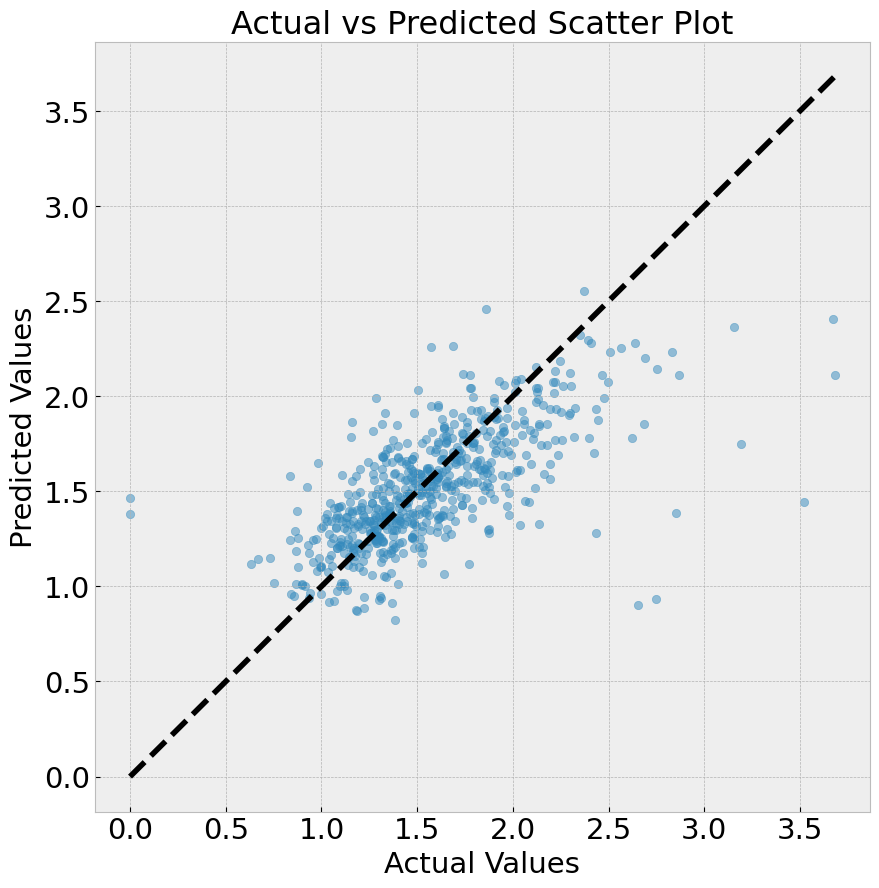

In [100]:
plt.figure(figsize=(10, 10))
plt.scatter(df_labels.iloc[-testX.size()[0]:][0], df_predict.iloc[-testX.size()[0]:][0], alpha=0.5)
plt.title('Actual vs Predicted Scatter Plot', fontsize=23)
plt.xlabel('Actual Values', fontsize=21)
plt.ylabel('Predicted Values', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.plot([df_labels.min(), df_labels.max()], [df_labels.min(), df_labels.max()], 'k--', lw=4)
plt.show()

The scatter plot shown illustrates the relationship between the actual and predicted values from my LSTM model. Each point represents an individual prediction, with the actual value on the x-axis and the predicted value on the y-axis. The dashed line represents the line of perfect prediction, where the predicted values would exactly match the actual values.

Observing the distribution of points, most appear to cluster around the line of perfect prediction, indicating a generally accurate model. However, there are points that deviate from this line, which represent less accurate predictions. The density of points near the line suggests that the model performs well, especially for values closer to the lower end of the scale. As the actual values increase, we observe some spread in predictions, which could indicate potential areas for model refinement. Overall, the close alignment of the majority of points with the line of perfect prediction demonstrates the effectiveness of the LSTM model in forecasting sales demand.